In [4]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import hashlib
import json
from datetime import datetime, timedelta

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, root_mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [5]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [6]:
end_date = datetime.now()
start_date = end_date - timedelta(days=60)

print("Start date:", start_date)
print("End date:", end_date)

Start date: 2025-10-02 00:49:28.987842
End date: 2025-12-01 00:49:28.987842


In [7]:
gold = yf.download("GC=F", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "Gold"})
silver = yf.download("SI=F", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "Silver"})
cad = yf.download("CADUSD=X", start=start_date, end=end_date, interval="30m", auto_adjust = False)[["Close"]].rename(columns={"Close": "CAD"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [8]:
all_prices = gold.join([silver, cad], how="outer")
all_prices.to_csv("prices_with_null.csv")

In [9]:
# filling missing values
all_prices = all_prices.ffill().bfill()

In [10]:
def create_sequences(df, window=20):
    X, y = [], []
    values = df.values
    for i in range(len(df) - window):
        X.append(values[i:i+window]) # past window prices
        y.append(values[i+window]) # next timestep prices
    return np.array(X), np.array(y)

In [11]:
window = 20
X, y = create_sequences(all_prices, window)
X_flat = X.reshape(X.shape[0], -1)

X_train, X_test, y_train, y_test = train_test_split(
    X_flat, y, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=20,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("MAE:")
print("Gold  :", mean_absolute_error(y_test[:,0], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test[:,1], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test[:,2], y_pred[:,2]))
print("RMSE:")
print("Gold  :", root_mean_squared_error(y_test[:,0], y_pred[:,0]))
print("Silver:", root_mean_squared_error(y_test[:,1], y_pred[:,1]))
print("CAD   :", root_mean_squared_error(y_test[:,2], y_pred[:,2]))
print("MAPE:")
mean_absolute_percentage_error
print("Gold  :", mean_absolute_percentage_error(y_test[:,0], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test[:,1], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test[:,2], y_pred[:,2]))

MAE:
Gold  : 8.815962885712615
Silver: 0.9094075061662659
CAD   : 0.0021117321264490685
RMSE:
Gold  : 12.240818104795583
Silver: 1.1790875851703029
CAD   : 0.0026074487715894144
MAPE:
Gold  : 0.00213381656544397
Silver: 0.01725490915226541
CAD   : 0.0029743866996717397


In [12]:
def forecast_interval(model, df, start_date, end_date, window=20):
    # date range at 30min freq
    future_index = pd.date_range(start=start_date, end=end_date, freq="30min")
    
    history = df.values[-window:].copy()
    predictions = []

    for _ in future_index:
        X_input = history.reshape(1, -1)
        y_pred = model.predict(X_input)[0]
        predictions.append(y_pred)
        history = np.vstack([history[1:], y_pred])

    pred_df = pd.DataFrame(predictions, index=future_index, columns=["Gold", "Silver", "CAD"])
    return pred_df

In [13]:
future_start = "2025-11-27"
future_end   = "2025-11-28"

forecast_df = forecast_interval(rf, all_prices, future_start, future_end, window)
print(forecast_df)

                            Gold    Silver       CAD
2025-11-27 00:00:00  4239.257760  52.84299  0.713713
2025-11-27 00:30:00  4238.433366  52.82232  0.713706
2025-11-27 01:00:00  4238.855168  52.71045  0.713629
2025-11-27 01:30:00  4238.957562  52.68387  0.713643
2025-11-27 02:00:00  4239.706559  52.64144  0.713577
2025-11-27 02:30:00  4240.074570  52.63067  0.713559
2025-11-27 03:00:00  4241.097379  52.54903  0.713437
2025-11-27 03:30:00  4241.292783  52.51491  0.713386
2025-11-27 04:00:00  4242.095787  52.46355  0.713319
2025-11-27 04:30:00  4242.421586  52.41298  0.713239
2025-11-27 05:00:00  4242.444584  52.38648  0.713197
2025-11-27 05:30:00  4242.512981  52.35527  0.713169
2025-11-27 06:00:00  4243.075987  52.27910  0.713108
2025-11-27 06:30:00  4244.197386  52.22148  0.713019
2025-11-27 07:00:00  4245.691186  52.11289  0.712923
2025-11-27 07:30:00  4246.082188  52.08025  0.712880
2025-11-27 08:00:00  4246.178587  52.04791  0.712851
2025-11-27 08:30:00  4246.405988  52.02644  0.

In [22]:
all_prices = gold.join([silver, cad], how="outer")
all_prices = all_prices.ffill().bfill()

df = all_prices.copy()

for col in ["Gold", "Silver", "CAD"]:
    df[f"{col}_return"] = df[col].pct_change()
    df[f"{col}_ma_5"] = df[col].rolling(5).mean()
    df[f"{col}_ma_10"] = df[col].rolling(10).mean()
    df[f"{col}_std_5"] = df[col].rolling(5).std()
    df[f"{col}_momentum"] = df[col] - df[col].shift(5)
    
# adding lag to be able to capture the time series
for col in ["Gold", "Silver", "CAD"]:
    for lag in range(1, 61):   # 20 lags = 10 hours of memory for 30m data
        df[f"{col}_lag_{lag}"] = df[col].shift(lag)

    
df = df.dropna()

target = df[["Gold", "Silver", "CAD"]]

features = df.drop(columns=["Gold", "Silver", "CAD"])

X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.2, shuffle=False
)

rf = RandomForestRegressor(
    n_estimators=700,
    max_depth=25,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

print("Improved MAE:")
print("Gold  :", mean_absolute_error(y_test["Gold"], y_pred[:,0]))
print("Silver:", mean_absolute_error(y_test["Silver"], y_pred[:,1]))
print("CAD   :", mean_absolute_error(y_test["CAD"], y_pred[:,2]))
print("RMSE:")
print("Gold  :", root_mean_squared_error(y_test["Gold"], y_pred[:,0]))
print("Silver:", root_mean_squared_error(y_test["Silver"], y_pred[:,1]))
print("CAD   :", root_mean_squared_error(y_test["CAD"], y_pred[:,2]))
print("MAPE:")
print("Gold  :", mean_absolute_percentage_error(y_test["Gold"], y_pred[:,0]))
print("Silver:", mean_absolute_percentage_error(y_test["Silver"], y_pred[:,1]))
print("CAD   :", mean_absolute_percentage_error(y_test["CAD"], y_pred[:,2]))

/tmp/ipykernel_16615/144308914.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/tmp/ipykernel_16615/144308914.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{col}_lag_{lag}"] = df[col].shift(lag)
/tmp/ipykernel_16615/144308914.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

Improved MAE:
Gold  : 3.8182961602408803
Silver: 0.9812377292830585
CAD   : 0.002451942335965835
RMSE:
Gold  : 6.609713434277935
Silver: 1.2805008493534091
CAD   : 0.0030043692215602595
MAPE:
Gold  : 0.0009224889946404259
Silver: 0.018610612894010926
CAD   : 0.0034536546558629456


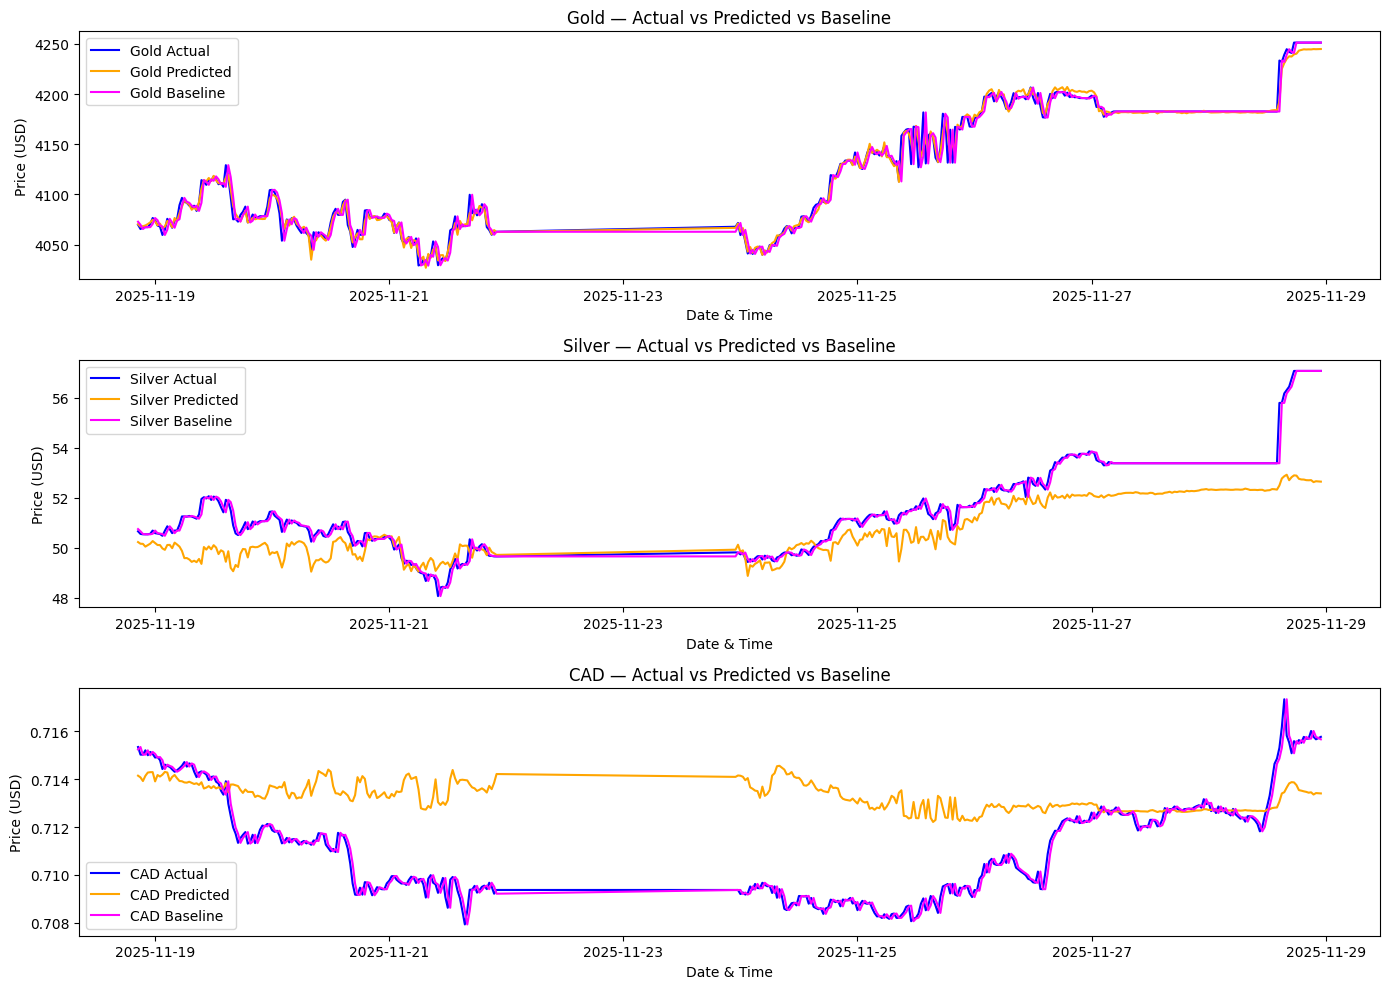

In [23]:
baseline = y_test.shift(1).dropna()

y_test_aligned = y_test.iloc[1:]

y_pred_aligned = y_pred[1: 1 + len(y_test_aligned)]

time_index = y_test_aligned.index

assets = ["Gold", "Silver", "CAD"]

plt.figure(figsize=(14, 10))

for i, asset in enumerate(assets):

    plt.subplot(3, 1, i+1)

    plt.plot(time_index, y_test_aligned[asset],
             label=f"{asset} Actual", color="blue")

    plt.plot(time_index, y_pred_aligned[:, i],
             label=f"{asset} Predicted", color="orange")

    plt.plot(time_index, baseline[asset],
             label=f"{asset} Baseline", color="magenta")

    plt.title(f"{asset} — Actual vs Predicted vs Baseline")
    plt.xlabel("Date & Time")
    plt.ylabel("Price (USD)")
    plt.legend()

plt.tight_layout()
plt.show()